In [1]:
# %pip install -q "torch" transformers "diffusers>=0.22.0" "controlnet-aux>=0.0.6" --index-url https://download.pytorch.org/whl/cpu
# %pip install -q "openvino>=2023.2.0" pillow gradio

In [2]:
from pathlib import Path

controlnet_id  = "lllyasviel/control_v11p_sd15_normalbae"
adapter_id = "latent-consistency/lcm-lora-sdv1-5"
stable_diffusion_id = "runwayml/stable-diffusion-v1-5"

TEXT_ENCODER_OV_PATH = Path('model/text_encoder.xml')
UNET_OV_PATH = Path('model/unet_controlnet.xml')
CONTROLNET_OV_PATH = Path('model/controlnet-normalbae.xml')
VAE_DECODER_OV_PATH = Path('model/vae_decoder.xml')
TOKENIZER_PATH = Path('model/tokenizer')
SCHEDULER_PATH = Path('model/scheduler')

skip_models = TEXT_ENCODER_OV_PATH.exists() and UNET_OV_PATH.exists() and CONTROLNET_OV_PATH.exists() and VAE_DECODER_OV_PATH.exists()

In [3]:
from diffusers import StableDiffusionControlNetPipeline, ControlNetModel
import gc


def load_orginal_pytorch_pipeline_componets(controlnet_id, satable_diffusion_id, adapter_id):
    # load controlnet model
    controlnet = ControlNetModel.from_pretrained(controlnet_id)
    # load stable diffusion pipeline
    pipe = StableDiffusionControlNetPipeline.from_pretrained(stable_diffusion_id, controlnet=controlnet)
    # load LCM LoRA weights
    pipe.load_lora_weights(adapter_id)
    # fuse LoRA weights with UNet
    pipe.fuse_lora()
    text_encoder = pipe.text_encoder
    text_encoder.eval()
    unet = pipe.unet
    unet.eval()
    vae = pipe.vae
    vae.eval()
    del pipe
    gc.collect()
    return controlnet, text_encoder, unet, vae

2023-11-20 13:36:04.777132: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-11-20 13:36:04.818012: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-11-20 13:36:05.513654: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [4]:
controlnet, text_encoder, unet, vae = None, None, None, None
if not skip_models:
    controller, text_encoder, unet, vae = load_original_pytorch_components

/home/ea/work/openvino_notebooks/test_env/lib/python3.8/site-packages/controlnet_aux/mediapipe_face/mediapipe_face_common.py:7: UserWarning: The module 'mediapipe' is not installed. The package will have limited functionality. Please install it using the command: pip install 'mediapipe'
  warnings.warn(


Loading base model ()...Done.
Removing last two layers (global_pool & classifier).


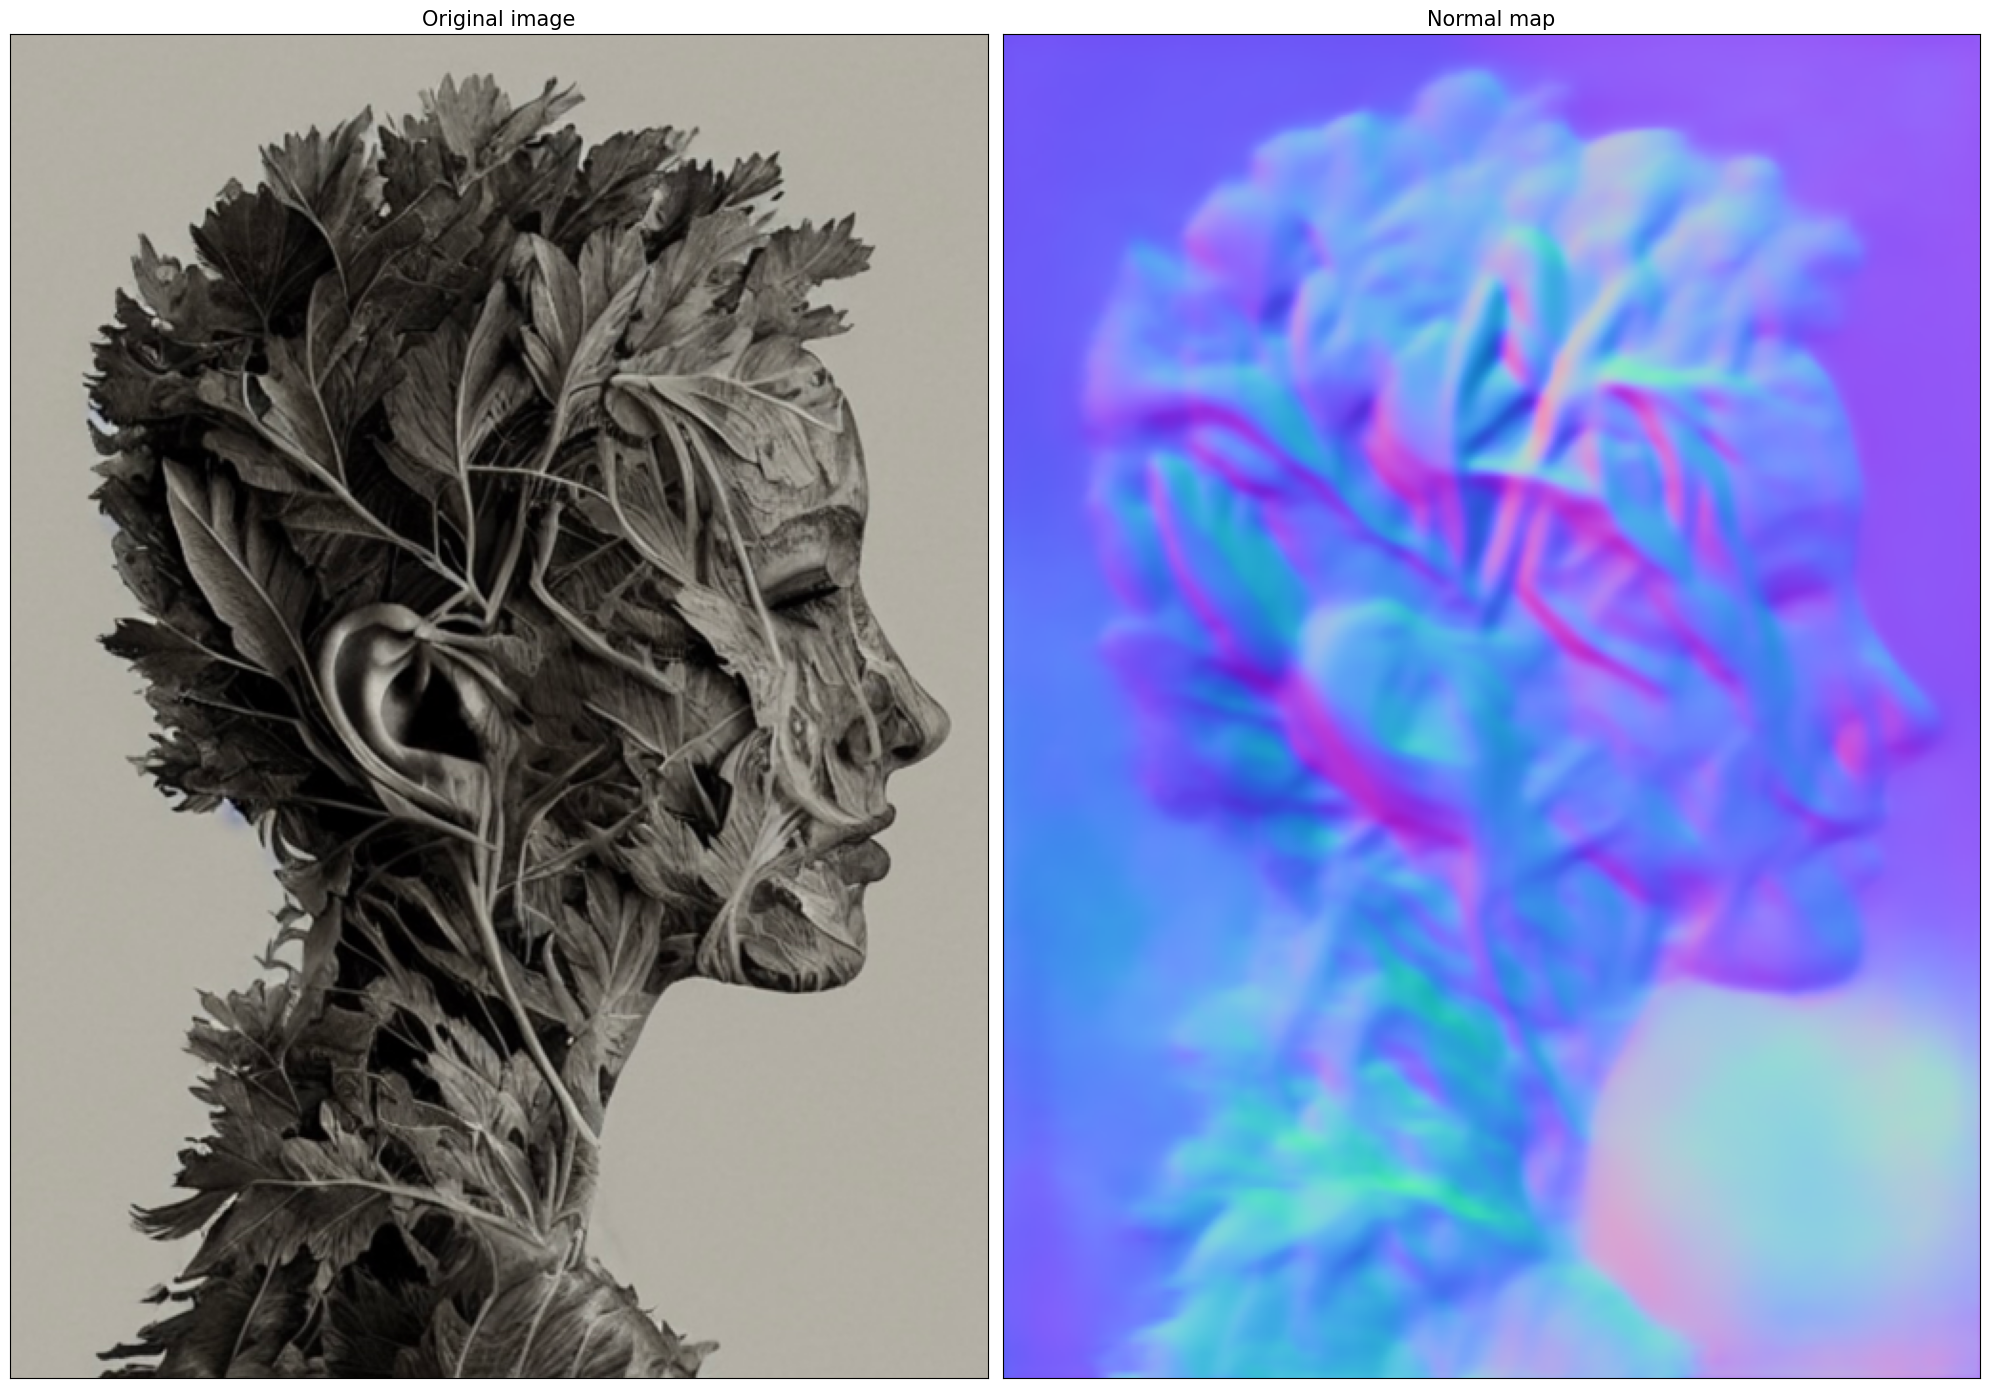

In [5]:
from controlnet_aux import NormalBaeDetector
from diffusers.utils import load_image
from urllib.request import urlretrieve
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np

example_image_url = "https://huggingface.co/lllyasviel/control_v11p_sd15_normalbae/resolve/main/images/input.png"
urlretrieve(example_image_url, "example.png")

processor = NormalBaeDetector.from_pretrained("lllyasviel/Annotators")

image = load_image("example.png")
control_image = processor(image)

def visualize_results(orig_img:Image.Image, normal_img:Image.Image, result_img:Image.Image=None, save_fig=False):
    """
    Helper function for results visualization
    
    Parameters:
       orig_img (Image.Image): original image
       skeleton_img (Image.Image): image with body pose keypoints
       result_img (Image.Image): generated image
    Returns:
       fig (matplotlib.pyplot.Figure): matplotlib generated figure contains drawing result
    """
    orig_title = "Original image"
    control_title = "Normal map"
    orig_img = orig_img.resize(normal_img.size if result_img is None else result_img.size)
    im_w, im_h = orig_img.size
    is_horizontal = im_h <= im_w
    figsize = (20, 20)
    num_images = 3 if result_img is not None else 2
    fig, axs = plt.subplots(num_images if is_horizontal else 1, 1 if is_horizontal else num_images, figsize=figsize, sharex='all', sharey='all')
    fig.patch.set_facecolor('white')
    list_axes = list(axs.flat)
    for a in list_axes:
        a.set_xticklabels([])
        a.set_yticklabels([])
        a.get_xaxis().set_visible(False)
        a.get_yaxis().set_visible(False)
        a.grid(False)
    list_axes[0].imshow(np.array(orig_img))
    list_axes[1].imshow(np.array(normal_img))
    list_axes[0].set_title(orig_title, fontsize=15)
    list_axes[1].set_title(control_title, fontsize=15) 
    if result_img is not None:
        list_axes[2].imshow(np.array(result_img))
        list_axes[2].set_title("Result", fontsize=15)
    
    fig.subplots_adjust(wspace=0.01 if is_horizontal else 0.00 , hspace=0.01 if is_horizontal else 0.1)
    fig.tight_layout()
    if save_fig:
        fig.savefig("result.png", bbox_inches='tight')
    return fig


fig = visualize_results(image, control_image)

In [6]:
import torch
import openvino as ov
import gc
from functools import partial

def cleanup_torchscript_cache():
    """An image with surface normal information, usually represented as a color-coded image.
    Helper for removing cached model representation
    """
    torch._C._jit_clear_class_registry()
    torch.jit._recursive.concrete_type_store = torch.jit._recursive.ConcreteTypeStore()
    torch.jit._state._clear_class_state()


def flattenize_inputs(inputs):
    flatten_inputs = []
    for input_data in inputs:
        if input_data is None:
            continue
        if isinstance(input_data, (list, tuple)):
            flatten_inputs.extend(flattenize_inputs(input_data))
        else:
            flatten_inputs.append(input_data)
    return flatten_inputs


dtype_mapping = {
    torch.float32: ov.Type.f32,
    torch.float64: ov.Type.f64,
    torch.int32: ov.Type.i32,
    torch.int64: ov.Type.i64
}


def prepare_input_info(input_dict):
    flatten_inputs = flattenize_inputs(inputs.values())
    input_info = []
    for input_data in flatten_inputs:
        updated_shape = list(input_data.shape)
        if updated_shape:
            updated_shape[0] = -1
        if input_data.ndim == 4:
            updated_shape[2] = -1
            updated_shape[3] = -1

        input_info.append((dtype_mapping[input_data.dtype], updated_shape))
    return input_info


inputs = {
    "sample": torch.randn((1, 4, 64, 64)),
    "timestep": torch.tensor(1, dtype=torch.float32),
    "encoder_hidden_states": torch.randn((1,77,768)),
    "controlnet_cond": torch.randn((1,3,512,512))
}


# Prepare conditional inputs for U-Net
if not UNET_OV_PATH.exists():    
    controlnet.eval()
    with torch.no_grad():
        down_block_res_samples, mid_block_res_sample = controlnet(**inputs, return_dict=False)
    
if not CONTROLNET_OV_PATH.exists():
    input_info  = prepare_input_info(inputs)
    with torch.no_grad():
        controlnet.forward = partial(controlnet.forward, return_dict=False)
        ov_model = ov.convert_model(controlnet, example_input=inputs, input=input_info)
        ov.save_model(ov_model, CONTROLNET_OV_PATH)
        del ov_model
        cleanup_torchscript_cache()
    print('ControlNet successfully converted to IR')
else:
    print(f"ControlNet will be loaded from {CONTROLNET_OV_PATH}")

del controlnet
gc.collect()

ControlNet will be loaded from model/controlnet-normalbae.xml


19

In [7]:
from typing import Tuple

class UnetWrapper(torch.nn.Module):
    def __init__(
        self, 
        unet, 
        sample_dtype=torch.float32, 
        timestep_dtype=torch.int64, 
        encoder_hidden_states=torch.float32, 
        down_block_additional_residuals=torch.float32, 
        mid_block_additional_residual=torch.float32
    ):
        super().__init__()
        self.unet = unet
        self.sample_dtype = sample_dtype
        self.timestep_dtype = timestep_dtype
        self.encoder_hidden_states_dtype = encoder_hidden_states
        self.down_block_additional_residuals_dtype = down_block_additional_residuals
        self.mid_block_additional_residual_dtype = mid_block_additional_residual

    def forward(
        self, 
        sample:torch.Tensor, 
        timestep:torch.Tensor, 
        encoder_hidden_states:torch.Tensor, 
        down_block_additional_residuals:Tuple[torch.Tensor],  
        mid_block_additional_residual:torch.Tensor
    ):
        sample.to(self.sample_dtype)
        timestep.to(self.timestep_dtype)
        encoder_hidden_states.to(self.encoder_hidden_states_dtype)
        down_block_additional_residuals = [res.to(self.down_block_additional_residuals_dtype) for res in down_block_additional_residuals]
        mid_block_additional_residual.to(self.mid_block_additional_residual_dtype)
        return self.unet(
            sample, 
            timestep, 
            encoder_hidden_states, 
            down_block_additional_residuals=down_block_additional_residuals, 
            mid_block_additional_residual=mid_block_additional_residual
        )



if not UNET_OV_PATH.exists():
    inputs.pop("controlnet_cond", None)
    inputs["down_block_additional_residuals"] = down_block_res_samples
    inputs["mid_block_additional_residual"] = mid_block_res_sample
    input_info = prepare_input_info(inputs)

    wrapped_unet = UnetWrapper(unet)
    wrapped_unet.eval()

    with torch.no_grad():
        ov_model = ov.convert_model(wrapped_unet, example_input=inputs)
        
    for (input_dtype, input_shape), input_tensor in zip(input_info, ov_model.inputs):
        input_tensor.get_node().set_partial_shape(input_shape)
        input_tensor.get_node().set_element_type(input_dtype)
    ov_model.validate_nodes_and_infer_types()
    ov.save_model(ov_model, UNET_OV_PATH)
    del ov_model
    cleanup_torchscript_cache()
    del wrapped_unet
    del unet
    gc.collect()
    print('Unet successfully converted to IR')
else:
    del unet
    print(f"Unet will be loaded from {UNET_OV_PATH}")
gc.collect()

Unet will be loaded from model/unet_controlnet.xml


0

In [8]:
def convert_encoder(text_encoder:torch.nn.Module, ir_path:Path):
    """
    Convert Text Encoder model to OpenVINO IR. 
    Function accepts text encoder model, prepares example inputs for conversion, and convert it to OpenVINO Model
    Parameters: 
        text_encoder (torch.nn.Module): text_encoder model
        ir_path (Path): File for storing model
    Returns:
        None
    """
    if not ir_path.exists():
        input_ids = torch.ones((1, 77), dtype=torch.long)
        # switch model to inference mode
        text_encoder.eval()

        # disable gradients calculation for reducing memory consumption
        with torch.no_grad():
            ov_model = ov.convert_model(
                text_encoder,  # model instance
                example_input=input_ids,  # inputs for model tracing
                input=([1,77],)
            )
            ov.save_model(ov_model, ir_path)
            del ov_model
        cleanup_torchscript_cache()
        print('Text Encoder successfully converted to IR')
    

if not TEXT_ENCODER_OV_PATH.exists():
    convert_encoder(text_encoder, TEXT_ENCODER_OV_PATH)
else:
    print(f"Text encoder will be loaded from {TEXT_ENCODER_OV_PATH}")
del text_encoder
gc.collect()

Text encoder will be loaded from model/text_encoder.xml


0

In [9]:
def convert_vae_decoder(vae: torch.nn.Module, ir_path: Path):
    """
    Convert VAE model to IR format. 
    Function accepts pipeline, creates wrapper class for export only necessary for inference part, 
    prepares example inputs for convert, 
    Parameters: 
        vae (torch.nn.Module): VAE model
        ir_path (Path): File for storing model
    Returns:
        None
    """
    class VAEDecoderWrapper(torch.nn.Module):
        def __init__(self, vae):
            super().__init__()
            self.vae = vae

        def forward(self, latents):
            return self.vae.decode(latents)

    if not ir_path.exists():
        vae_decoder = VAEDecoderWrapper(vae)
        latents = torch.zeros((1, 4, 64, 64))

        vae_decoder.eval()
        with torch.no_grad():
            ov_model = ov.convert_model(vae_decoder, example_input=latents, input=[-1, 4, -1, -1])
            ov.save_model(ov_model, ir_path)
        del ov_model
        cleanup_torchscript_cache()
        print('VAE decoder successfully converted to IR')


if not VAE_DECODER_OV_PATH.exists():
    convert_vae_decoder(vae, VAE_DECODER_OV_PATH)
else:
    print(f"VAE decoder will be loaded from {VAE_DECODER_OV_PATH}")

del vae

VAE decoder will be loaded from model/vae_decoder.xml


In [10]:
from diffusers import DiffusionPipeline
from transformers import CLIPTokenizer
from typing import Union, List, Optional, Tuple
import cv2
import numpy as np


def scale_fit_to_window(dst_width:int, dst_height:int, image_width:int, image_height:int):
    """
    Preprocessing helper function for calculating image size for resize with peserving original aspect ratio 
    and fitting image to specific window size
    
    Parameters:
      dst_width (int): destination window width
      dst_height (int): destination window height
      image_width (int): source image width
      image_height (int): source image height
    Returns:
      result_width (int): calculated width for resize
      result_height (int): calculated height for resize
    """
    im_scale = min(dst_height / image_height, dst_width / image_width)
    return int(im_scale * image_width), int(im_scale * image_height)


def preprocess(image: Image.Image, dst_height=512, dst_width=512):
    """
    Image preprocessing function. Takes image in PIL.Image format, resizes it to keep aspect ration and fits to model input window 512x512,
    then converts it to np.ndarray and adds padding with zeros on right or bottom side of image (depends from aspect ratio), after that
    converts data to float32 data type and change range of values from [0, 255] to [-1, 1], finally, converts data layout from planar NHWC to NCHW.
    The function returns preprocessed input tensor and padding size, which can be used in postprocessing.
    
    Parameters:
      image (Image.Image): input image
    Returns:
       image (np.ndarray): preprocessed image tensor
       pad (Tuple[int]): pading size for each dimension for restoring image size in postprocessing
    """
    src_width, src_height = image.size
    res_width, res_height = scale_fit_to_window(dst_width, dst_height, src_width, src_height)
    image = np.array(image.resize((res_width, res_height), resample=Image.Resampling.LANCZOS))[None, :]
    pad_width = dst_width - res_width
    pad_height = dst_height - res_height
    pad = ((0, 0), (0, pad_height), (0, pad_width), (0, 0))
    image = np.pad(image, pad, mode="constant")
    image = image.astype(np.float32) / 255.0
    image = image.transpose(0, 3, 1, 2)
    return image, pad


def randn_tensor(
    shape: Union[Tuple, List],
    dtype: Optional[np.dtype] = torch.float32,
):
    """
    Helper function for generation random values tensor with given shape and data type
    
    Parameters:
      shape (Union[Tuple, List]): shape for filling random values
      dtype (np.dtype, *optiona*, np.float32): data type for result
    Returns:
      latents (np.ndarray): tensor with random values with given data type and shape (usually represents noise in latent space)
    """
    latents = torch.randn(shape, dtype=dtype)
    return latents.numpy()


class OVContrlNetStableDiffusionPipeline(DiffusionPipeline):
    """
    OpenVINO inference pipeline for Stable Diffusion with ControlNet guidence
    """
    def __init__(
        self,
        tokenizer: CLIPTokenizer,
        scheduler,
        core: ov.Core,
        controlnet: ov.Model,
        text_encoder: ov.Model,
        unet: ov.Model,
        vae_decoder: ov.Model,
        device:str = "AUTO"
    ):
        super().__init__()
        self.tokenizer = tokenizer
        self.vae_scale_factor = 8
        self.scheduler = scheduler
        self.load_models(core, device, controlnet, text_encoder, unet, vae_decoder)

    def load_models(self, core: ov.Core, device: str, controlnet:ov.Model, text_encoder: ov.Model, unet: ov.Model, vae_decoder: ov.Model):
        """
        Function for loading models on device using OpenVINO
        
        Parameters:
          core (Core): OpenVINO runtime Core class instance
          device (str): inference device
          controlnet (Model): OpenVINO Model object represents ControlNet
          text_encoder (Model): OpenVINO Model object represents text encoder
          unet (Model): OpenVINO Model object represents UNet
          vae_decoder (Model): OpenVINO Model object represents vae decoder
        Returns
          None
        """
        self.text_encoder = core.compile_model(text_encoder, device)
        self.controlnet = core.compile_model(controlnet, device)
        self.unet = core.compile_model(unet, device)
        ov_config = {"INFERENCE_PRECISION_HINT": "f32"} if device != "CPU" else {}
        self.vae_decoder = core.compile_model(vae_decoder, device, ov_config)

    def __call__(
        self,
        prompt: Union[str, List[str]],
        image: Image.Image,
        num_inference_steps: int = 4,
        height=512,
        width=512,
        negative_prompt: Union[str, List[str]] = None,
        guidance_scale: float = 0.5,
        controlnet_conditioning_scale: float = 1.0,
        latents: Optional[np.array] = None,
        output_type: Optional[str] = "pil",
    ):
        """
        Function invoked when calling the pipeline for generation.

        Parameters:
            prompt (`str` or `List[str]`):
                The prompt or prompts to guide the image generation.
            image (`Image.Image`):
                `Image`, or tensor representing an image batch which will be repainted according to `prompt`.
            num_inference_steps (`int`, *optional*, defaults to 100):
                The number of denoising steps. More denoising steps usually lead to a higher quality image at the
                expense of slower inference.
            negative_prompt (`str` or `List[str]`):
                negative prompt or prompts for generation
            guidance_scale (`float`, *optional*, defaults to 7.5):
                Guidance scale as defined in [Classifier-Free Diffusion Guidance](https://arxiv.org/abs/2207.12598).
                `guidance_scale` is defined as `w` of equation 2. of [Imagen
                Paper](https://arxiv.org/pdf/2205.11487.pdf). Guidance scale is enabled by setting `guidance_scale >
                1`. Higher guidance scale encourages to generate images that are closely linked to the text `prompt`,
                usually at the expense of lower image quality. This pipeline requires a value of at least `1`.
            latents (`np.ndarray`, *optional*):
                Pre-generated noisy latents, sampled from a Gaussian distribution, to be used as inputs for image
                generation. Can be used to tweak the same generation with different prompts. If not provided, a latents
                tensor will ge generated by sampling using the supplied random `generator`.
            output_type (`str`, *optional*, defaults to `"pil"`):
                The output format of the generate image. Choose between
                [PIL](https://pillow.readthedocs.io/en/stable/): `Image.Image` or `np.array`.
        Returns:
            image ([List[Union[np.ndarray, Image.Image]]): generaited images
            
        """

        # 1. Define call parameters
        batch_size = 1 if isinstance(prompt, str) else len(prompt)
        if guidance_scale < 1 and negative_prompt:
            guidance_scale += 1
        # here `guidance_scale` is defined analog to the guidance weight `w` of equation (2)
        # of the Imagen paper: https://arxiv.org/pdf/2205.11487.pdf . `guidance_scale = 1`
        # corresponds to doing no classifier free guidance.
        do_classifier_free_guidance = guidance_scale > 1.0
        # 2. Encode input prompt
        text_embeddings = self._encode_prompt(prompt, do_classifier_free_guidance=do_classifier_free_guidance, negative_prompt=negative_prompt)

        # 3. Preprocess image
        orig_width, orig_height = image.size
        image, pad = preprocess(image, height, width)
        #height, width = image.shape[-2:]
        if do_classifier_free_guidance:
            image = np.concatenate(([image] * 2))

        # 4. set timesteps
        self.scheduler.set_timesteps(num_inference_steps)
        timesteps = self.scheduler.timesteps

        # 5. Prepare latent variables
        num_channels_latents = 4
        latents = self.prepare_latents(
            batch_size,
            num_channels_latents,
            height,
            width,
            latents=latents,
        )

        # 6. Denoising loop
        with self.progress_bar(total=num_inference_steps) as progress_bar:
            for i, t in enumerate(timesteps):
                # Expand the latents if we are doing classifier free guidance.
                # The latents are expanded 3 times because for pix2pix the guidance\
                # is applied for both the text and the input image.
                latent_model_input = np.concatenate(
                    [latents] * 2) if do_classifier_free_guidance else latents
                latent_model_input = self.scheduler.scale_model_input(latent_model_input, t)

                result = self.controlnet([latent_model_input, t, text_embeddings, image], share_inputs=True, share_outputs=True)
                down_and_mid_blok_samples = [sample * controlnet_conditioning_scale for _, sample in result.items()]

                # predict the noise residual
                noise_pred = self.unet([latent_model_input, t, text_embeddings, *down_and_mid_blok_samples], share_inputs=True, share_outputs=True)[0]

                # perform guidance
                if do_classifier_free_guidance:
                    noise_pred_uncond, noise_pred_text = noise_pred[0], noise_pred[1]
                    noise_pred = noise_pred_uncond + guidance_scale * (noise_pred_text - noise_pred_uncond)

                # compute the previous noisy sample x_t -> x_t-1
                latents = self.scheduler.step(torch.from_numpy(noise_pred), t, torch.from_numpy(latents)).prev_sample.numpy()
                progress_bar.update()

        # 7. Post-processing
        image = self.decode_latents(latents, pad)

        # 8. Convert to PIL
        if output_type == "pil":
            image = self.numpy_to_pil(image)
            image = [img.resize((orig_width, orig_height), Image.Resampling.LANCZOS) for img in image]
        else:
            image = [cv2.resize(img, (orig_width, orig_width))
                     for img in image]

        return image

    def _encode_prompt(self, prompt:Union[str, List[str]], num_images_per_prompt:int = 1, do_classifier_free_guidance:bool = True, negative_prompt:Union[str, List[str]] = None):
        """
        Encodes the prompt into text encoder hidden states.

        Parameters:
            prompt (str or list(str)): prompt to be encoded
            num_images_per_prompt (int): number of images that should be generated per prompt
            do_classifier_free_guidance (bool): whether to use classifier free guidance or not
            negative_prompt (str or list(str)): negative prompt to be encoded
        Returns:
            text_embeddings (np.ndarray): text encoder hidden states
        """
        batch_size = len(prompt) if isinstance(prompt, list) else 1

        # tokenize input prompts
        text_inputs = self.tokenizer(
            prompt,
            padding="max_length",
            max_length=self.tokenizer.model_max_length,
            truncation=True,
            return_tensors="np",
        )
        text_input_ids = text_inputs.input_ids

        text_embeddings = self.text_encoder(text_input_ids, share_inputs=True, share_outputs=True)[0]

        # duplicate text embeddings for each generation per prompt
        if num_images_per_prompt != 1:
            bs_embed, seq_len, _ = text_embeddings.shape
            text_embeddings = np.tile(
                text_embeddings, (1, num_images_per_prompt, 1))
            text_embeddings = np.reshape(
                text_embeddings, (bs_embed * num_images_per_prompt, seq_len, -1))

        # get unconditional embeddings for classifier free guidance
        if do_classifier_free_guidance:
            uncond_tokens: List[str]
            max_length = text_input_ids.shape[-1]
            if negative_prompt is None:
                uncond_tokens = [""] * batch_size
            elif isinstance(negative_prompt, str):
                uncond_tokens = [negative_prompt]
            else:
                uncond_tokens = negative_prompt
            uncond_input = self.tokenizer(
                uncond_tokens,
                padding="max_length",
                max_length=max_length,
                truncation=True,
                return_tensors="np",
            )

            uncond_embeddings = self.text_encoder(uncond_input.input_ids, share_inputs=True, share_outputs=True)[0]

            # duplicate unconditional embeddings for each generation per prompt, using mps friendly method
            seq_len = uncond_embeddings.shape[1]
            uncond_embeddings = np.tile(uncond_embeddings, (1, num_images_per_prompt, 1))
            uncond_embeddings = np.reshape(uncond_embeddings, (batch_size * num_images_per_prompt, seq_len, -1))

            # For classifier free guidance, we need to do two forward passes.
            # Here we concatenate the unconditional and text embeddings into a single batch
            # to avoid doing two forward passes
            text_embeddings = np.concatenate([uncond_embeddings, text_embeddings])

        return text_embeddings

    def prepare_latents(self, batch_size:int, num_channels_latents:int, height:int, width:int, dtype:np.dtype = torch.float32, latents:np.ndarray = None):
        """
        Preparing noise to image generation. If initial latents are not provided, they will be generated randomly, 
        then prepared latents scaled by the standard deviation required by the scheduler
        
        Parameters:
           batch_size (int): input batch size
           num_channels_latents (int): number of channels for noise generation
           height (int): image height
           width (int): image width
           dtype (np.dtype, *optional*, np.float32): dtype for latents generation
           latents (np.ndarray, *optional*, None): initial latent noise tensor, if not provided will be generated
        Returns:
           latents (np.ndarray): scaled initial noise for diffusion
        """
        shape = (batch_size, num_channels_latents, height // self.vae_scale_factor, width // self.vae_scale_factor)
        if latents is None:
            latents = randn_tensor(shape, dtype=dtype)
        else:
            latents = latents

        # scale the initial noise by the standard deviation required by the scheduler
        latents = latents * self.scheduler.init_noise_sigma
        return latents

    def decode_latents(self, latents:np.array, pad:Tuple[int]):
        """
        Decode predicted image from latent space using VAE Decoder and unpad image result
        
        Parameters:
           latents (np.ndarray): image encoded in diffusion latent space
           pad (Tuple[int]): each side padding sizes obtained on preprocessing step
        Returns:
           image: decoded by VAE decoder image
        """
        latents = 1 / 0.18215 * latents
        image = self.vae_decoder(latents)[0]
        (_, end_h), (_, end_w) = pad[1:3]
        h, w = image.shape[2:]
        unpad_h = h - end_h
        unpad_w = w - end_w
        image = image[:, :, :unpad_h, :unpad_w]
        image = np.clip(image / 2 + 0.5, 0, 1)
        image = np.transpose(image, (0, 2, 3, 1))
        return image

In [11]:
from diffusers import LCMScheduler
from transformers import AutoTokenizer

if not TOKENIZER_PATH.exists():
    tokenizer = AutoTokenizer.from_pretrained(stable_diffusion_id, subfolder="tokenizer")
    tokenizer.save_pretrained(TOKENIZER_PATH)
else:
    tokenizer = AutoTokenizer.from_pretrained(TOKENIZER_PATH)
if not SCHEDULER_PATH.exists():
    scheduler = LCMScheduler.from_pretrained(stable_diffusion_id, subfolder="tokenizer")
    scheduler.config.save_pretrained(SCHEDULER_PATH)
else:
    scheduler = LCMScheduler.from_config(SCHEDULER_PATH)

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
/home/ea/work/openvino_notebooks/test_env/lib/python3.8/site-packages/diffusers/configuration_utils.py:239: FutureWarning: It is deprecated to pass a pretrained model name or path to `from_config`.If you were trying to load a scheduler, please use <class 'diffusers.schedulers.scheduling_lcm.LCMScheduler'>.from_pretrained(...) instead. Otherwise, please make sure to pass a configuration dictionary instead. This functionality will be removed in v1.0.0.
  deprecate("config-passed-as-path", "1.0.0", deprecation_message, standard_warn=False)


In [12]:
import ipywidgets as widgets

core = ov.Core()

device = widgets.Dropdown(
    options=core.available_devices + ["AUTO"],
    value='CPU',
    description='Device:',
    disabled=False,
)

device

Dropdown(description='Device:', options=('CPU', 'GPU', 'AUTO'), value='CPU')

In [13]:
ov_pipe = OVContrlNetStableDiffusionPipeline(tokenizer, scheduler, core, CONTROLNET_OV_PATH, TEXT_ENCODER_OV_PATH, UNET_OV_PATH, VAE_DECODER_OV_PATH, device=device.value)

  0%|          | 0/4 [00:00<?, ?it/s]

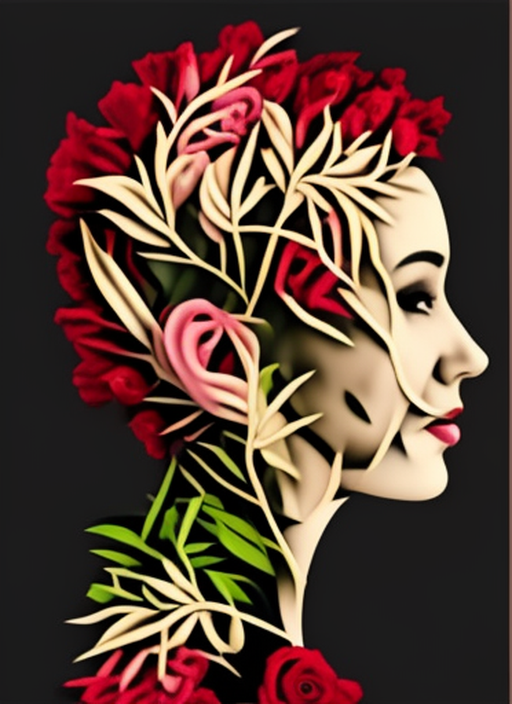

In [14]:
prompt = "A head full of roses"
torch.manual_seed(4257)

result = ov_pipe(prompt, control_image, 4)
result[0]

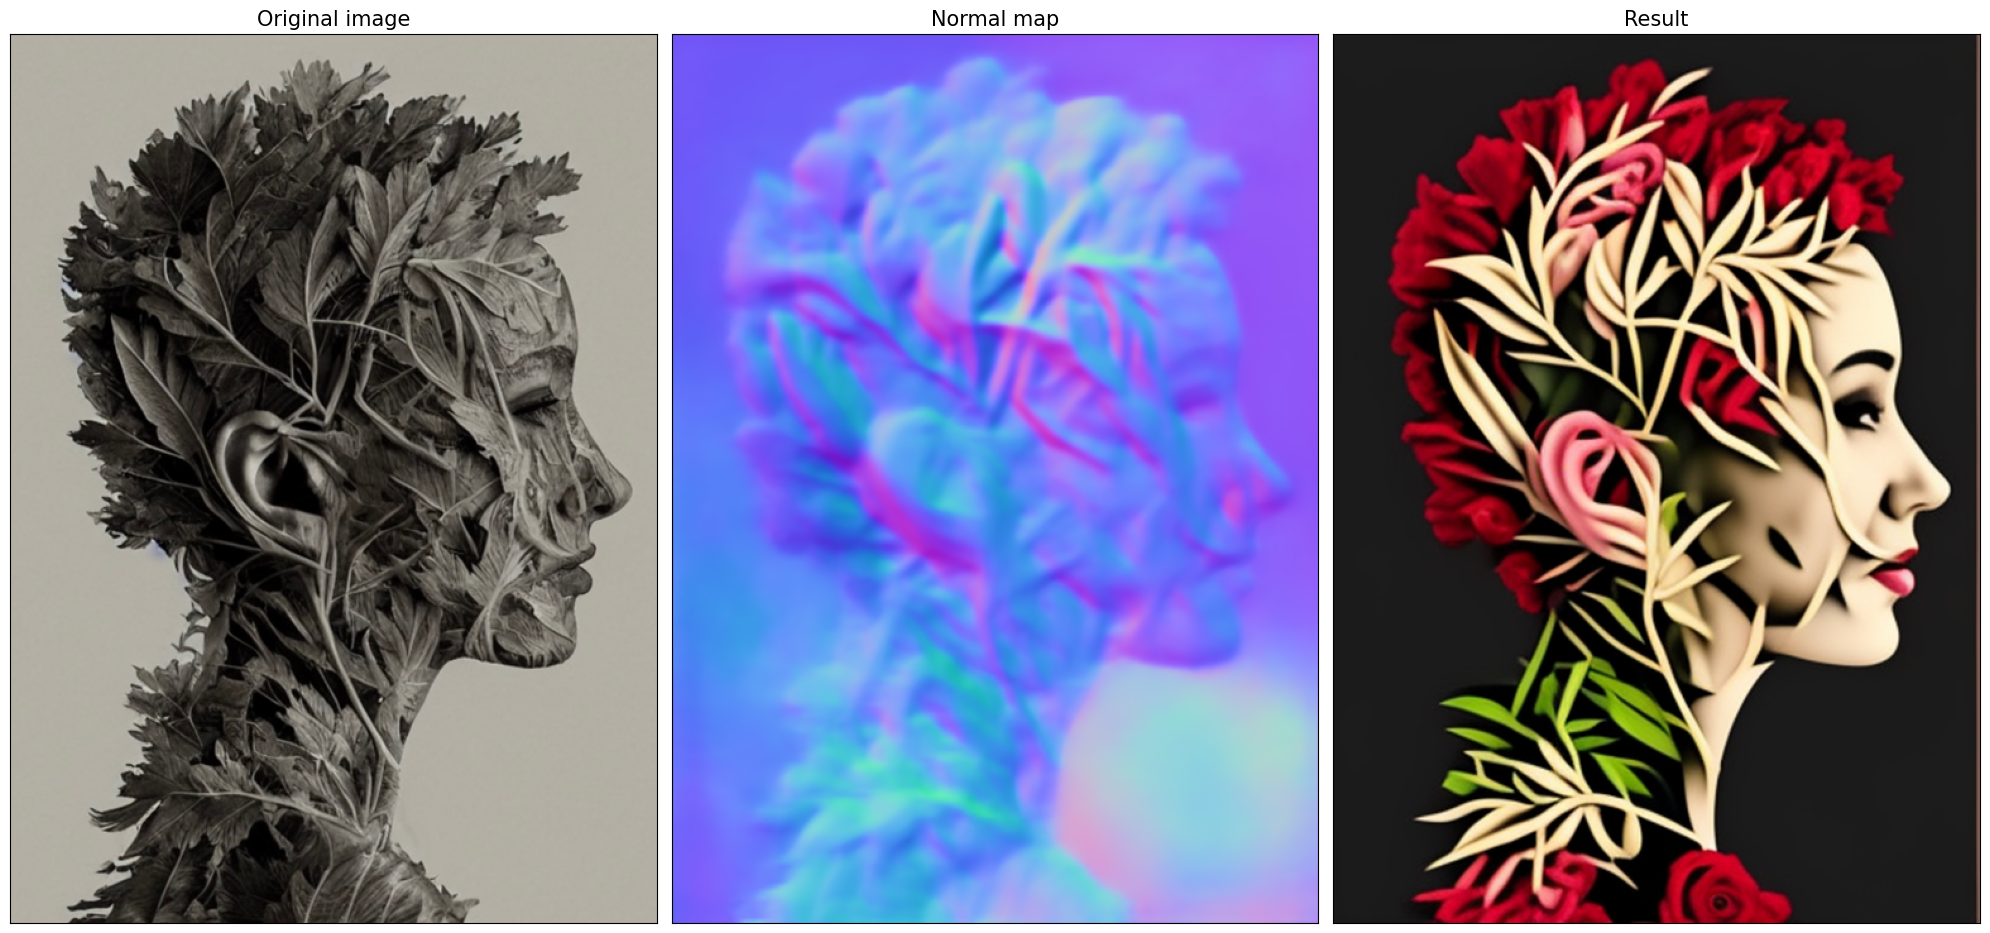

In [15]:
fig = visualize_results(image, control_image, result[0])

In [ ]:
import gradio as gr
MAX_SEED = np.iinfo(np.int32).max

gr.close_all()
with gr.Blocks() as demo:
    with gr.Row():
        with gr.Column():
            inp_img = gr.Image(label="Input image")
            normal_btn = gr.Button("Get Normal Map")
            examples = gr.Examples(["example.png"], inp_img)
        with gr.Column(visible=False) as step1:
            out_normal = gr.Image(label="Normal Map", type='pil')
            inp_prompt = gr.Textbox(
                "A head full of roses", label="Prompt"
            )
            inp_neg_prompt = gr.Textbox(
                "",
                label="Negative prompt",
            )
            guidance_scale = gr.Slider(
                label="Guidance scale for base",
                minimum=0.1,
                maximum=2,
                step=0.1,
                value=0.5,
            )
            inp_seed = gr.Slider(label="Seed", value=42, maximum=MAX_SEED)
            inp_steps = gr.Slider(label="Steps", value=4, minimum=1, maximum=50)
            btn = gr.Button()
        with gr.Column(visible=False) as step2:
            out_result = gr.Image(label="Result")

    def extract_normal_map(img):
        if img is None:
            raise gr.Error("Please upload the image or use one from the examples list")
        return {step1: gr.update(visible=True), step2: gr.update(visible=True), out_normal: processor(img)}

    def generate(control_img, prompt, negative_prompt, seed, num_steps, guidance_scale, progress=gr.Progress(track_tqdm=True)):
        torch.manual_seed(seed)
        result = ov_pipe(prompt, control_img, num_steps, guidance_scale=guidance_scale, negative_prompt=negative_prompt)[0]
        return result

    normal_btn.click(extract_normal_map, inp_img, [out_normal, step1, step2])
    btn.click(generate, [out_normal, inp_prompt, inp_neg_prompt, inp_seed, inp_steps, guidance_scale], out_result)


try:
    demo.queue().launch(debug=True)
except Exception:
    demo.queue().launch(share=True, debug=True)
# if you are launching remotely, specify server_name and server_port
# demo.launch(server_name='your server name', server_port='server port in int')
# Read more in the docs: https://gradio.app/docs/

Running on local URL:  http://127.0.0.1:7860

To create a public link, set `share=True` in `launch()`.
